In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.integrate import quad


class Simaan():
    def __init__(self):
        #Simulation Time
        self.start_t = 0
        self.passo = 0.0001
        self.end_t = 4

        #Uses the already created Time Scale
        self.T = list(np.arange(self.start_t,self.end_t,self.passo))
        self.n = len(self.T)
        
        #Cardiovascular System
        self.HR = 60
        self.Emax = 2.5
        self.Emin = 0.06
        self.tc = 60/self.HR
        self.t_max = 0.2 + 0.1555*self.tc;
      
        self.En = self.elastance(self.T)
        self.E = (self.Emax - self.Emin) * self.En + self.Emin
        

        #Cardiovascular System Model Parameters (from Simaan2009)

        self.Rs = 1
        self.Rm = 0.005

        self.Cae = 4.4000
        self.Ra = 0.0010
        self.Rc = 0.0398
        self.Cs = 1.3300
        self.Cao = 0.0800
        self.Ls = 0.0005

        self.Vo = 10


        #PreAllocating
        w, h = 5, 40000;
        Matrix = [[0 for x in range(w)] for y in range(h)] 

        self.Pao = np.zeros_like(self.T)
        self.Qa = np.zeros_like(self.T)
        self.Vve = np.zeros_like(self.T)
        self.Pas = np.zeros_like(self.T)
        self.Pae = np.zeros_like(self.T)
        self.Pve = np.zeros_like(self.T)
        self.Dm_ = np.zeros_like(self.T)
        self.Da_ = np.zeros_like(self.T)


        #Initial Conditions
        self.Pao[0] = 90
        self.Qa[0] = 0
        self.Vve[0] = 140 #Left Ventricular Volume
        self.Pas[0] = 90
        self.Pae[0] = 5


        self.Pve[0] = self.E[0]*(self.Vve[0] - self.Vo)

        #x = [x1 x2 x3 x4 x5]
        self.x = np.transpose([self.Pao[0], self.Qa[0], self.Vve[0], self.Pas[0], self.Pae[0]])

        #Initial States of diodes
        self.Dm = 0
        self.Da = 0

        self.Da_[0] = self.Da
        self.Dm_[0] = self.Dm

    def elastance(self, t):

        tn = np.asarray(t)%self.tc/self.t_max;
        En = 1.55 * np.power(np.asarray(tn)/.7, 1.9) / (1 + np.power(np.asarray(tn)/.7, 1.9)) / (1 + np.power(np.asarray(tn)/1.17, 21.9))
        return (self.Emax-self.Emin)*En + self.Emin
     
        
        




In [ ]:
opa = Simaan()
a = np.linspace(0, 0.8, 100)
#print(np.array(list(map(opa.elastance, a))))
b = np.array(list(map(opa.elastance, a)))


In [9]:
def runkut4(passo,A,x,B):
    A = np.asarray(A);
    x = np.asarray(x);
    B = np.asarray(B);

    xdot = np.matmul(A, x) + B;
    kx1 = passo*xdot
    x1 = x + 0.5*kx1

    xdot = np.matmul(A, x1) + B
    kx2 = passo*xdot
    x1 = x + 0.5*kx2

    xdot = np.matmul(A, x1) + B
    kx3 = passo*xdot
    x1 = x + kx3

    xdot = np.matmul(A, x1) + B
    kx4 = passo*xdot

    value = np.asarray(x + (kx1 + 2*kx2 + 2*kx3 + kx4)/6)

    return value


In [10]:
import operator
import functools as ft 

model = Simaan()
print(model.n)
for i in range(model.n):
    if(i == 39999):
      break
    if model.Pae[i] >= model.Pve[i]:
      model.Dm = 1
    else:
      model.Dm = 0

    if model.Pve[i] >= model.Pao[i]:
      model.Da = 1
    else:
      model.Da = 0


    #Matriz A
    # lambda = E(i) - Emin*En(i)
    a13 = (model.Da)/(model.Ra) * (model.E[i])
    a33 = -1*( (model.Dm)/(model.Rm) + (model.Da)/(model.Ra) ) * model.E[i]
    a53 = (model.Dm)/(model.Rm) * model.E[i]
    a55 = - (1/(model.Rs)  + (model.Dm)/(model.Rm))


    # x = [ x1 x2 x3 x4 x5 ]
    A = [[0], [0], [0], [0], [0]];
    A[0] = [-((model.Da)/(model.Ra)), -1, a13, 0, 0]/np.asarray(model.Cao)
    A[1] = [1, -(model.Rc), 0, -1, 0]/np.asarray(model.Ls)
    A[2] = [(model.Da)/(model.Ra), 0, a33, 0, (model.Dm)/(model.Rm)]
    A[3] = [0, 1, 0, -1/(model.Rs), 1/(model.Rs)]/np.asarray(model.Cs);
    A[4] = [0, 0, a53, 1/(model.Rs), a55]/np.asarray(model.Cae);
    A = np.asarray(A);

    
    #Matriz B
    B = [-(((model.Da)/(model.Ra))*model.E[i]*model.Vo)/model.Cao,
         0,
         ((model.Dm)/(model.Rm) + (model.Da)/(model.Ra))*model.E[i]*model.Vo,
         0,
         ( -(model.Dm)/(model.Rm)*model.E[i]*model.Vo)/model.Cae]

    model.x =  runkut4(model.passo, A, model.x, B)

    model.Pao[i+1] =  model.x[0] 
    model.Qa[i+1] =  model.x[1] 
    model.Vve[i+1] =  model.x[2]
    model.Pas[i+1] =  model.x[3]
    model.Pae[i+1] =  model.x[4]

    model.Dm_[i+1] = model.Da
    model.Dm_[i+1] = model.Dm

    model.Pve[i+1] = model.E[i+1] * (model.Vve[i+1] - model.Vo)


    




    


    


40000


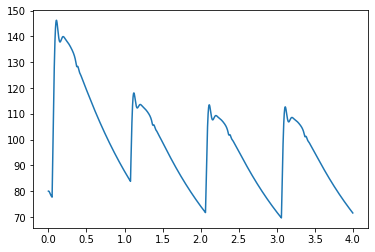

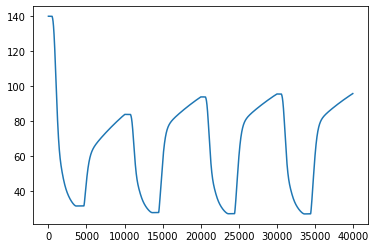

In [11]:
#PLOT

import matplotlib.pyplot as plt

plt.plot(model.T, model.Pao)
plt.show()

#Elastancia
plt.plot(model.Vve)